In [1]:
!python --version

Python 3.10.0


## Imports

In [40]:
import os 
import re
import string
import numpy as np
import spacy as sp
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Carregando os dados

In [3]:
dataset_path = 'dataset/'
dataset_name = 'dataset.csv'

dataset = pd.read_csv(os.path.join(dataset_path, dataset_name))
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",educação
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"educação,orgão público"
518,Empresas e órgãos públicos,orgão público
519,DGE – Departamento de Gestão Estratégica Metas...,orgão público


## Exploratória

In [4]:
texto = 'sentence'
setor = 'category'

dataset[texto].sample(5).tolist()

['Chamamento Público para Credenciamento de Prestação.',
 'Setor Único - Inteira R$\xa0390,00 Lote 7',
 'Governo do Estado anuncia retorno à fase vermelha do Plano São Paulo em 09/04/2021.',
 'Para se enquadrar nesta categoria é necessário apresentar o comprovante de produtor rural, o ITR – Imposto sobre propriedade Territorial Rural.',
 'Iniciativas de professores, alunos, colaboradores e parceiros fizeram a diferença na vida de muitas pessoas em 2020.']

In [5]:
dataset[setor].value_counts()

category
orgão público               140
educação                    107
indústrias                   89
varejo                       85
finanças                     54
finanças,varejo              13
educação,orgão público        9
indústrias,varejo             7
educação,indústrias           5
finanças,orgão público        4
finanças,indústrias           3
indústrias,orgão público      2
educação,finanças             2
varejo,indústrias             1
Name: count, dtype: int64

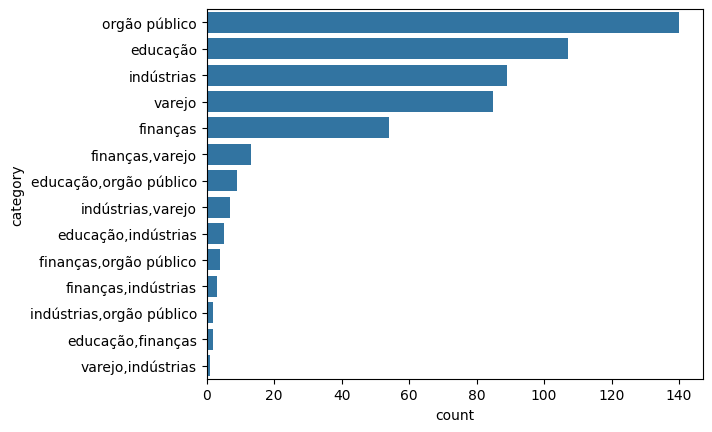

In [6]:
ordenados = dataset[setor].value_counts().index
sns.countplot(dataset[setor], order=ordenados);

Observando a frequência com que os setores são atribuídos aos textos, fica claro que o 'multi-labeling' não é tão presente, ou seja,
existem bem mais textos classificados à apenas um setor. 

Nesse momento, é importante decidir qual será a abordagem da modelagem. A priori, tendo a acreditar que modelar um multi-label não vá ser eficiente dado esse 'desbalanceamento'.

Uma alternativa é associar cada texto à um único setor.
- **E aqueles que são associados a dois setores?**

    Estes serão duplicados e associados aos dois setores. 
    
    Exemplo:
    
     'ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS EM VALPARAÍSO.' -> 'educação'   
     'ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS EM VALPARAÍSO.' -> 'orgão público'

    Assim, quando o modelo receber um input que se referir tanto ao setor 'educação' quanto ao setor 'orgão público', ele tenderá a dar pesos mais altos para essas duas classes. 

- **O modelo não vai ficar confuso tendo duas labels para o mesmo texto?**

    Essa abordagem de fato pode atrapalhar o aprendizado do modelo e diminuir a acurácia, no entanto, parte-se do pressuposto de que o modelo tenderá a atribuir maiores pesos para os textos relacionados à um setor em específico.

## Duplicando os textos com mais de um setor atribuído


In [7]:
## A label com dois setor está assumindo o tipo 'string' única, precisamos fazer com que seja uma lista com duas strings
dataset[setor] = [set.split(',') for set in dataset[setor]]
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",[orgão público]
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",[finanças]
2,Então encontraremos na próxima aula.,[educação]
3,Veja os resultados da categoria de ofertas do ...,[indústrias]
4,"Além disso, a embalagem é reutilizável e 100% ...","[indústrias, varejo]"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",[educação]
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"[educação, orgão público]"
518,Empresas e órgãos públicos,[orgão público]
519,DGE – Departamento de Gestão Estratégica Metas...,[orgão público]


In [8]:
## Duplicando as linhas e reiniciando o index
dataset = dataset.explode(setor).reset_index(drop=True)
dataset

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...",indústrias
...,...,...
562,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,educação
563,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,orgão público
564,Empresas e órgãos públicos,orgão público
565,DGE – Departamento de Gestão Estratégica Metas...,orgão público


## Tratamento dos textos

Uma vez com o dataset de textos e labels, é necessário fazer o tratamento dos textos para tornar o aprendizado do modelo mais eficiente. Para isso, é comum fazer a remoção de caracteres especiais e pontuações, assim como a  realização da tokenização (processo que divide o texto em unidades menores [palavras ou subpalavras]). Além disso, tambem devemos converter o texto para letras minúsculas para garantir consistência na contagem de palavras.

- Remover a acentuação.
- Remover caracteres especiais.
- Remover as 'stop words' que são palavras normalmente encaradas como 'ruído' no texto. 

Isso é importante para reduzirmos a dimensão de features e facilitar a identificação de padrões mais relevantes.

In [9]:
## Definindo stop words 
nlp = sp.blank("pt")
stop_words = sp.lang.pt.STOP_WORDS
[sw for sw in stop_words][:10]

['maiorias',
 'eventual',
 'cujo',
 'para',
 'aí',
 'esse',
 'segundo',
 'à',
 'por',
 'a']

In [10]:
## Caracteres especiais
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
## Usando re (Regular Expression)
exemplo = 'Ele gosta de caçar'
re.sub(r"[ç]", "c", exemplo)  #Removendo o 'ç'

'Ele gosta de cacar'

In [12]:
def cleaning(text):
    text = text.lower()

    text = re.sub(r"[!@#%&$*º“”—-]", "", text)
    text = re.sub(r"[àáâãäåã]", "a", text)
    text = re.sub(r"[èéêë]", "e", text)
    text = re.sub(r"[ìíîï]", "i", text)
    text = re.sub(r"[òóôõö]", "o", text)
    text = re.sub(r"[ùúûü]", "u", text)
    text = re.sub(r"[ýÿ]", "y", text)
    text = re.sub(r"[ç]", "c", text)
    text = re.sub(r"[0-9]", "", text)

    text = text.lower()
    document = nlp(text)

    words = []
    for token in document:
        words.append(token.text)

    words = [word for word in words if word not in stop_words and word not in string.punctuation] 
    words = ' '.join([str(element) for element in words])

    return words

In [13]:
## Comparando texto original com o texto processado
for text in dataset[texto].sample(5).tolist():
    print(text)
    print(cleaning(text))
    print('\n')

EM CONDIÇÕES PARTICULARES, QUAL O INTERVALO RECOMENDADO DE TROCA DO ÓLEO DO MOTOR?
condicoes particulares intervalo recomendado troca oleo motor


Segunda via de Infração de trânsito.
via infracao transito


O desemprego é extremamente elevado e a desigualdade de renda é aproximadamente igual à do Brasil .
desemprego extremamente elevado desigualdade renda aproximadamente igual brasil


Nova Chevrolet S10 High Country 2022 , preto ouro.
chevrolet s high country   preto ouro


Anos Iniciais do Ensino Fundamental.
anos iniciais ensino fundamental




In [14]:
dataset[texto] = [cleaning(text) for text in dataset[texto]]
dataset[setor] = [cleaning(text) for text in dataset[setor]]

dataset

,sentence,category
0,auxiliodoenca previdenciario beneficios especi...,orgao publico
1,pagar contas atraso r.,financas
2,entao encontraremos proxima aula,educacao
3,resultados categoria ofertas modelo nissan kicks,industrias
4,alem embalagem reutilizavel reciclavel,industrias
...,...,...
562,estudantes rede municipal voltam aulas valparaiso,educacao
563,estudantes rede municipal voltam aulas valparaiso,orgao publico
564,empresas orgaos publicos,orgao publico
565,dge – departamento gestao estrategica metas na...,orgao publico


#### Tokenização

Antes da tokenização, vamos definir X como os textos e y sendo a representação númerica de cada setor (aplicando o label enconding)

In [15]:
X = dataset[texto]

enc = LabelEncoder()
y = enc.fit_transform(dataset[setor])

In [16]:
print('X >>\n',X[:5])
print('-----')
print('y >>',y[:5])

X >>
 0    auxiliodoenca previdenciario beneficios especi...
1                               pagar contas atraso r.
2                     entao encontraremos proxima aula
3     resultados categoria ofertas modelo nissan kicks
4             alem embalagem reutilizavel   reciclavel
Name: sentence, dtype: object
-----
y >> [3 1 0 2 2]


In [17]:
## Construindo o tokenizer (tendo 10 mil como o tamanho do vocabulario alvo)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X, target_vocab_size=10000)

In [18]:
## Tamanho do vocabulário
tokenizer.vocab_size

2233

In [19]:
tokenizer.subwords[:5]

['   ', 'voce_', 'carro_', 'x_', 'sao_']

Exemplo de como funciona a tokenização:

In [20]:
ids = tokenizer.encode('Aprenda LIBRAS')
ids

[2042, 2089, 116, 2053, 2050, 2043, 2059, 2042, 2060]

In [21]:
text = tokenizer.decode(ids)
text

'Aprenda LIBRAS'

___

In [22]:
data_inputs = [tokenizer.encode(sentence) for sentence in X]
data_inputs[:5]

[[616, 208, 103, 92, 27, 123],
 [77, 263, 1836, 2091, 2023],
 [536, 1508, 121, 284],
 [196, 595, 25, 1149, 7, 467],
 [104, 145, 114, 1, 370]]

#### Padding

Uma vez que muitos modelos exigem que o dado de entrada sejam de uma dimensão em específico, vamos aplicar o padding para que todos os inputs sejam do mesmo tamanho. 

In [23]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=50)

In [24]:
data_inputs[:2]

array([[ 616,  208,  103,   92,   27,  123,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  77,  263, 1836, 2091, 2023,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])

## Modelagem

Como um primeiro modelo, optei criar uma Rede Neural Convolucional (CNN) que receberá os textos no formato `data_inputs`. Essa CNN processará o texto ao longo de camadas de convolução e pooling e, por fim, retornará a probabilidade do texto de entrada estar associado a cada classe possível.

Primeiro é necessário separar os dados de treino e os dados de teste.

In [25]:
data_labels = np.array(y)
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.1,
                                                                        stratify = data_labels)

In [26]:
print('Shape dos dados de treinamento:',f'Inputs: {train_inputs.shape} Labels: {train_labels.shape}')
print('Shape dos dados de teste:',f'Inputs: {test_inputs.shape} Labels: {test_labels.shape}')

Shape dos dados de treinamento: Inputs: (510, 50) Labels: (510,)
Shape dos dados de teste: Inputs: (57, 50) Labels: (57,)


Criando o modelo

In [105]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=False,
               name='dcnn'):

    ## Inicializando modelo
    super(DCNN, self).__init__(name=name)

    ## Primeira camada (Embeddings)
    self.embedding = layers.Embedding(vocab_size, emb_dim)

    ## Segunda camada (Kernels)
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    ## Terceira camanda (Pooling)
    self.pool = layers.GlobalMaxPool1D()
    # self.batchnorm = layers.BatchNormalization()

    ## A saída da camada pooling, já é uma camada flatten

    ## Rede densa
    self.dense_1 = layers.Dense(units=ffn_units, activation='relu')
    self.dropout = layers.Dropout(rate=dropout_rate)

    if nb_classes == 2:
      self.last_dense = layers.Dense(units=1, activation='sigmoid')
    else:
      self.last_dense = layers.Dense(units=nb_classes,activation='softmax')

  def call(self, inputs, training):
    # Função de chamada que define o passo de propagação para frente do modelo

    # Camada de embeddings: converte os índices de palavras em vetores de embedding
    x = self.embedding(inputs)

    # Convolução de bigrama seguida por pooling
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)

    # Convolução de trigrama seguida por pooling
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)

    # Convolução de trigrama seguida por pooling
    x_3 = self.trigram(x)
    x_3 = self.pool(x_3)

    # Convolução de quatrigrama seguida por pooling
    x_4 = self.fourgram(x)
    x_4 = self.pool(x_4)

    # Convolução de quatrigrama seguida por pooling
    x_5 = self.fourgram(x)
    x_5 = self.pool(x_5)

    # Concatenando as saídas das convoluções de bigrama e trigrama
    merged = tf.concat([x_1,x_2,x_3,x_4,x_5], axis=-1) 
    merged = self.dense_1(merged) # processa a concatenação das saídas das camadas de pooling
    merged = self.dropout(merged, training=training) # dropout para evitar overfitting
    output = self.last_dense(merged) #ultima camada
   
    return output

Iniciando o Treinamento 

In [129]:
## Parametros
vocab_size = tokenizer.vocab_size
emb_dim = 128
nb_filters = 50
ffn_units = 128
batch_size = 64
nb_classes = len(set(train_labels))
dropout_rate = 0.2
nb_epochs = 100

In [130]:
## Inicializando modelo
model = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [131]:
## Compilando
if nb_classes == 2:
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [132]:
history = model.fit(train_inputs, train_labels,
            batch_size = batch_size,
            epochs = nb_epochs,
            verbose = 1,
            validation_split = .1)

results = model.evaluate(test_inputs, test_labels, batch_size=batch_size)
print('loss: ',results[0],'\nacurácia: ',results[1])

Epoch 1/100


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.2041 - loss: 1.6063 - val_accuracy: 0.2745 - val_loss: 1.5927
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2809 - loss: 1.5190 - val_accuracy: 0.2745 - val_loss: 1.5926
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3579 - loss: 1.4432 - val_accuracy: 0.2941 - val_loss: 1.5653
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6264 - loss: 1.3145 - val_accuracy: 0.3529 - val_loss: 1.5228
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8102 - loss: 1.1144 - val_accuracy: 0.3922 - val_loss: 1.4443
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8548 - loss: 0.8340 - val_accuracy: 0.4510 - val_loss: 1.3297
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9074 - loss: 0.5451 - val_accuracy: 0.4706 - val_loss: 1.2349
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9307 - loss: 0.3319 - val_accuracy: 0.5490 - val_loss: 1.2147
Epo

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


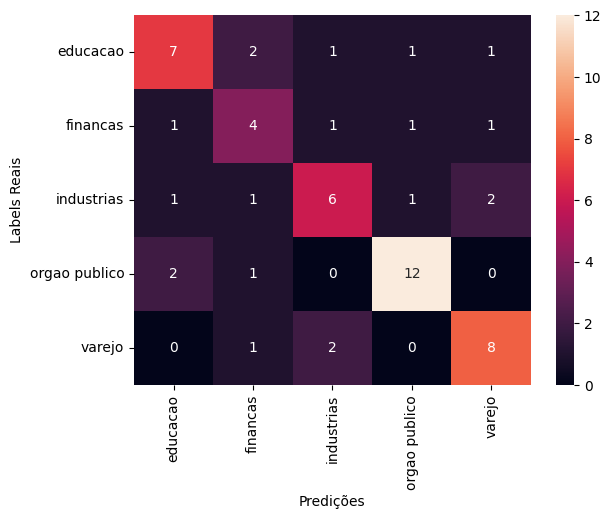

In [133]:
y_pred_test = [np.argmax(y_pred_test) for y_pred_test in model.predict(test_inputs)]
cm = confusion_matrix(test_labels, y_pred_test)

# Definindo os rótulos das classes
classes = [enc.inverse_transform([i])[0] for i in range(5)]

# Plot do heatmap
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)

# Definindo os rótulos dos eixos
plt.xlabel('Predições')
plt.ylabel('Labels Reais')

# Mostrando o gráfico
plt.show()

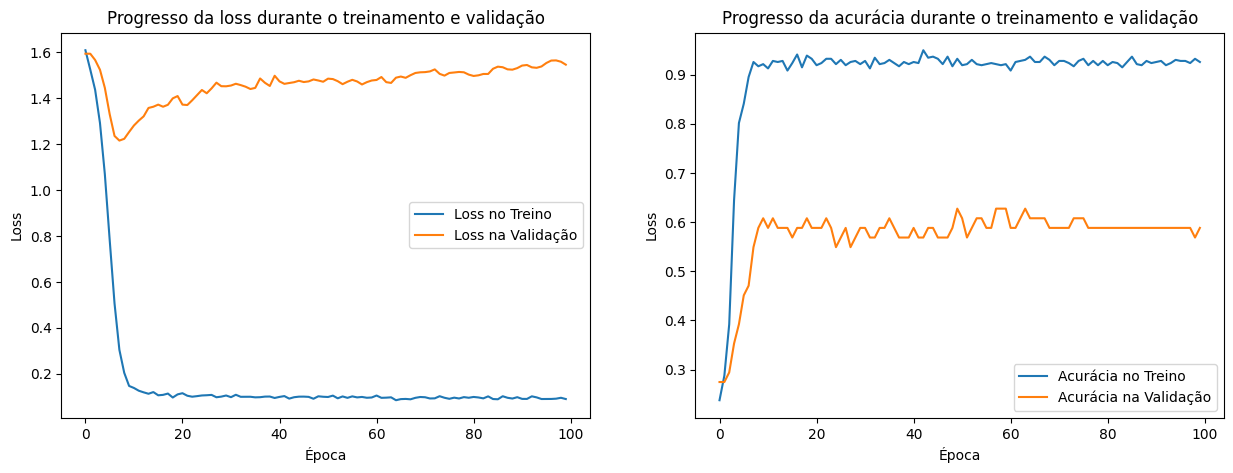

In [134]:
# Define o tamanho da figura
plt.figure(figsize=(15, 5))

# Primeiro subplot para loss
plt.subplot(1, 2, 1)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Progresso da loss durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend(['Loss no Treino', 'Loss na Validação'])

# Segundo subplot para accuracy
plt.subplot(1, 2, 2)  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Progresso da acurácia durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend(['Acurácia no Treino', 'Acurácia na Validação']);

In [135]:
model.save('CNNMoldel.h5')